In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def normalize(x, mu, std):
    # return x
    return (x - mu) / std

def create_data_guacamol(chemprop_model_path, target_columns):
    gold_data_path = "guacamol_benchmark/guacamol_dataset/guacamol_sample_test.csv"
    pred_data_path = os.path.join(chemprop_model_path, "test_unc.csv")
    gold_data = pd.read_csv(gold_data_path)
    gold_data = gold_data[["smiles"]+target_columns]
    pred_data = pd.read_csv(pred_data_path)

    rename_dict = {target: target+" prediction" for target in target_columns}
    pred_data = pred_data.rename(columns=rename_dict).drop(["smiles"],axis=1)
    return pd.concat([gold_data, pred_data], axis = 1)

def create_data(chemprop_model_path, target_columns, scaler_dict, uncertainty_method="evidential_total",normalize_data=True):
    gold_data_path = os.path.join(chemprop_model_path, "test_full.csv")
    pred_data_path = os.path.join(chemprop_model_path, "test_unc.csv")
    gold_data = pd.read_csv(gold_data_path)
    pred_data = pd.read_csv(pred_data_path)
    # # normalization
    if normalize_data:
        for target in target_columns:
            mean, std = scaler_dict[target]
            pred_data[target] = [normalize(t, mean, std) for t in pred_data[target]]
            gold_data[target] = [normalize(t, mean, std) for t in gold_data[target]]
            pred_data[target+"_{}_uncal_var".format(uncertainty_method)] = [t/(std**2) for t in pred_data[target+"_{}_uncal_var".format(uncertainty_method)]]

    rename_dict = {target: target+" prediction" for target in target_columns}
    pred_data = pred_data.rename(columns=rename_dict).drop(["smiles"],axis=1)
    return pd.concat([gold_data, pred_data], axis = 1)

def create_plot(data, target_columns, dataset):
    save_dir = "docs/plot_parity/{}".format(dataset)
    os.makedirs(save_dir, exist_ok=True)
    for target in target_columns:
        min_point = min(min(data[target]), min(data[target+" prediction"]))
        max_point = max(max(data[target]), max(data[target+" prediction"]))
        points = np.linspace(min_point,max_point,20)
        rmse = np.sqrt(mean_squared_error(data[target], data[target+" prediction"]))
        mae = mean_absolute_error(data[target], data[target+" prediction"])
        r2 = r2_score(data[target], data[target+" prediction"])
        print("RMSE, MAE, R2 score")
        print("{:.3f}, {:.3f}, {:.3f}".format(rmse, mae, r2))
        plt.figure(figsize=(4.5,4.5), dpi=100)
        plt.plot(points, points, color='black', linestyle='--')
        # plt.scatter(x=data[target], y=data[target+" prediction"])
        sns.scatterplot(data=data, x=target, y=target+" prediction")
        plt.xlabel("normalized "+target+" (-)", fontsize=14)
        plt.ylabel(target+" prediction"+" (-)", fontsize=14)
        plt.text(0.1, 0.9, r'$R^2$ = ' + f'{r2:.3f}', transform=plt.gca().transAxes, fontsize=13)
        plt.savefig(os.path.join(save_dir, "{}.svg".format(target)), format="svg", bbox_inches='tight')

def truncate_unc(data, target_columns, trunc_values,uncertainty_method="evidential_total"):
    data_copy = data.copy()
    for target, trunc_value in zip(target_columns, trunc_values):
        var_name = target + "_{}_uncal_var".format(uncertainty_method)
        new_values = [trunc_value if v > trunc_value else v for v in data[var_name]]
        data_copy[var_name] = new_values
    return data_copy

def create_single_unc_plot(data, target, uncertainty_method="evidential_total", xlabel=False, ylabel=False, color_bar=True, save_path=None):
    cmap = cm.viridis
    target_name_dict = {"1syh score":"1SYH score (-)", "4lde score":"4LDE score (-)", "6y2f score":"6Y2F score (-)",
                    "singlet-triplet value":"Singlet-triplet gap (eV)", "oscillator strength":"Oscillator strength (-)", 
                    "abs_diff_vee":"Abs. diff.of VEE (eV)",
                    "activation_energy":"Activation energy (kcal/mol)", "reaction_energy":"Reaction energy (kcal/mol)",
                    "1syh_score":"1SYH score (-)", "4lde_score":"4LDE score (-)", "6y2f_score":"6Y2F score (-)",
                    "singlet-triplet_value":"Singlet-triplet gap (eV)", "oscillator_strength":"Oscillator strength (-)", 
                    'similarity_Aripiprazole':'Similarity to Aripiprazole (-)  ',
                    'similarity_Albuterol': 'Similarity to Albuterol (-)', 'similarity_Mestranol':'Similarity to Mestranol (-)',
                    'similarity_Tadalafil': 'Similarity to Tadalafil (-)', 'similarity_Sildenafil':'Similarity to Sildenafil (-)',
                    'similarity_Camphor': 'Similarity to Camphor (-)', 'similarity_Menthol': 'Similarity to Menthol (-)',
                    'similarity_Fexofenadine': 'Similarity to Fexofenadine (-)   ', 'similarity_Ranolazine': 'Smilarity to Ranolazine (-)',
                    'logP': 'logP (-)', "tpsa": "TPSA ($\AA^2$)"}
    var_name = target + "_{}_uncal_var".format(uncertainty_method)
    min_point = min(min(data[target]), min(data[target+" prediction"]))
    max_point = max(max(data[target]), max(data[target+" prediction"]))
    points = np.linspace(min_point,max_point,20)

    r2 = r2_score(data[target], data[target+" prediction"])
    fig = plt.figure(figsize=(4.5,4.5), dpi=200)
    plt.plot(points, points, color='gray', linestyle='--')
    
    sns.scatterplot(data=data.sort_values(by = var_name, axis = 0,ascending=False),
                        x=target, y=target+" prediction", hue=var_name, palette=cmap, legend=False,
                        s=10, alpha=0.65)
    # plt.scatter(data[target], data[target+" prediction"], alpha=0.15, c="black", s=7)
    if xlabel:
        plt.xlabel("Reference value", fontsize=18)
    else:
        plt.xlabel("")
    if ylabel:
        plt.ylabel("Prediction", fontsize=18)
    else:
        plt.ylabel("")
    if target_name_dict.get(target):
        plt.title(target_name_dict[target], fontsize=18)
    else:
        plt.title(target, fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.text(0.1, 0.9, r'$R^2$ = ' + f'{r2:.3f}', transform=plt.gca().transAxes, fontsize=18)
    if target in ["similarity_Menthol", "similarity_Camphor", "similarity_Sildenafil"]:
        plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    if color_bar:
        norm = mpl.colors.Normalize(vmin=min(data[var_name]), vmax=max(data[var_name]))
        cax = fig.add_axes([0.91, 0.107, 0.065, 0.77])
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax, orientation='vertical',)
                               # label='Model uncertainty variance')
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1,1))  # This line is optional; adjust as necessary.
        cbar.ax.yaxis.set_major_formatter(formatter)
        cbar.ax.tick_params(labelsize=14)
        # cbar.set_label(label='Model uncertainty variance',size=13)
    # plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

def replace_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df.loc[df[column_name] < lower_bound, column_name] = lower_bound
    df.loc[df[column_name] > upper_bound, column_name] = upper_bound
    return df

## Plot all parity plots

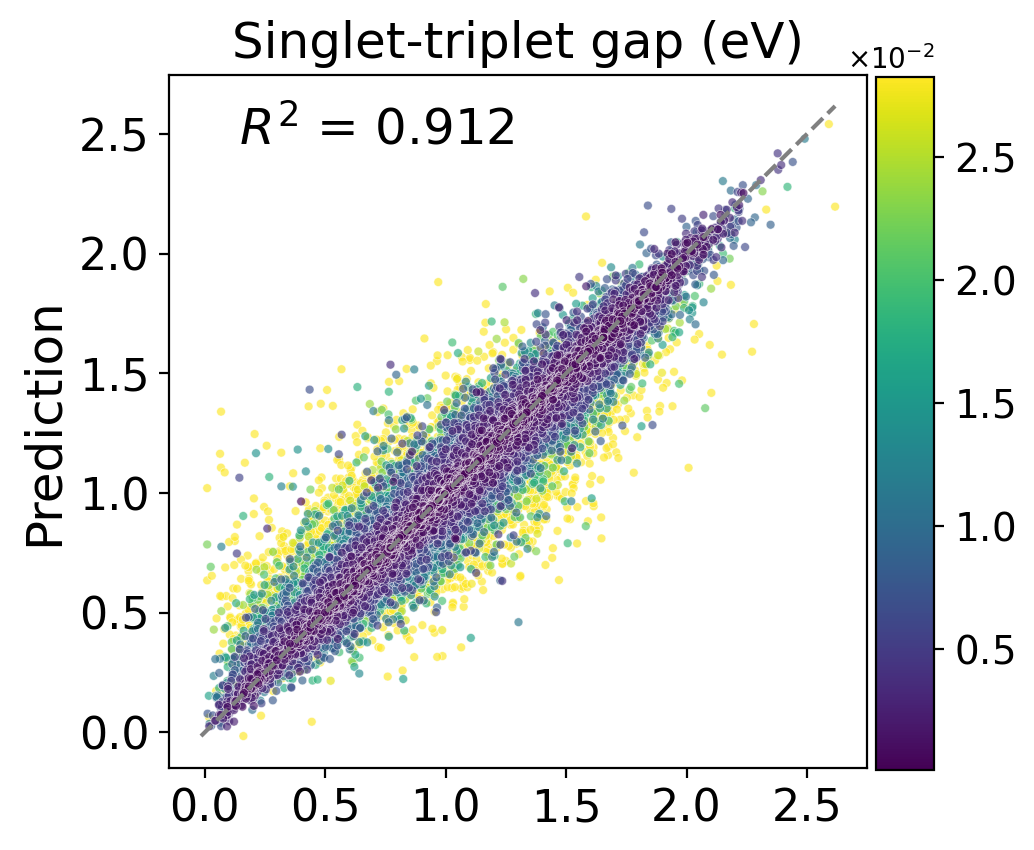

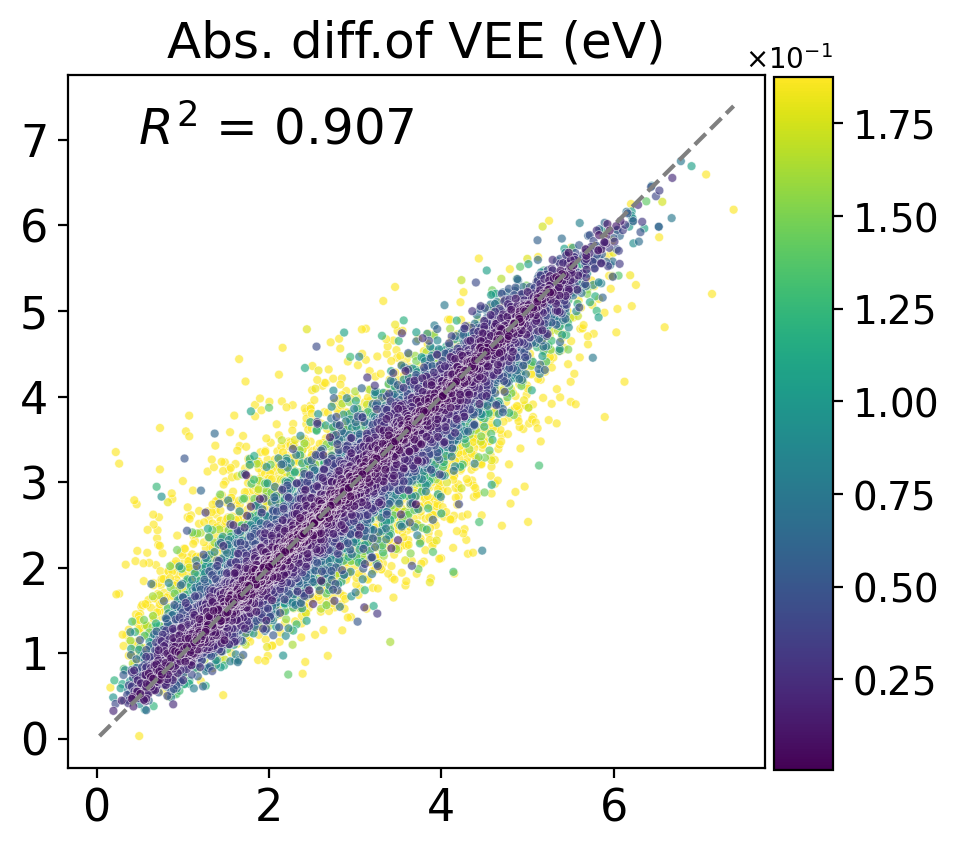

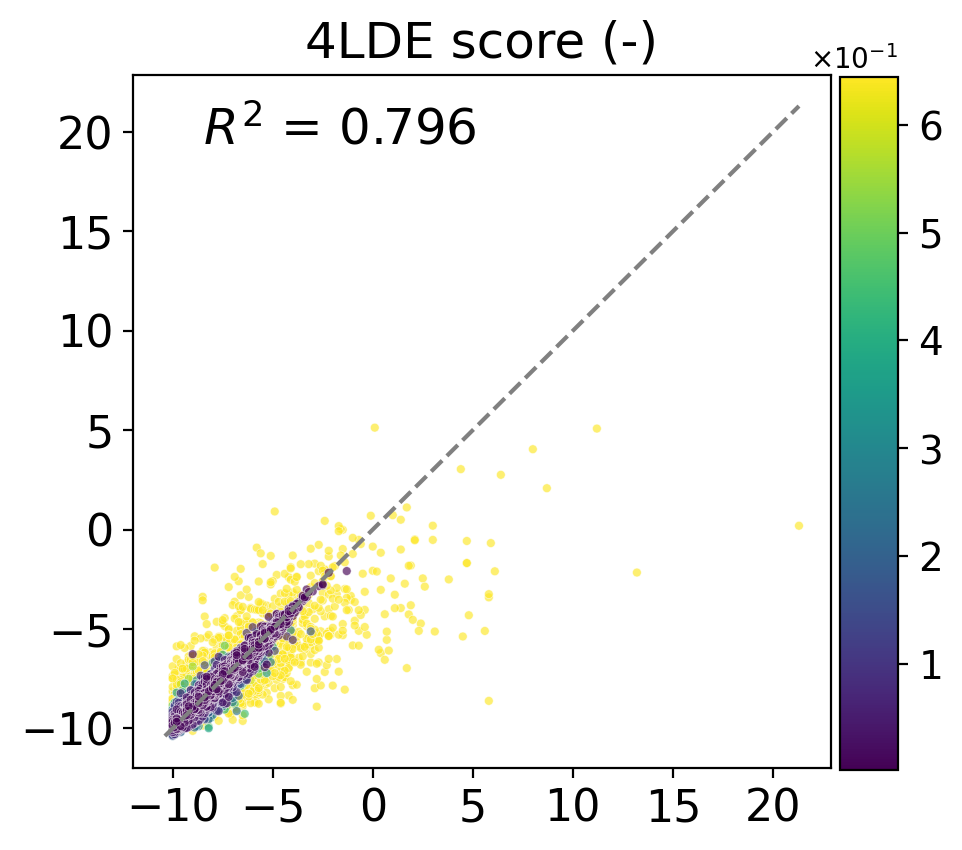

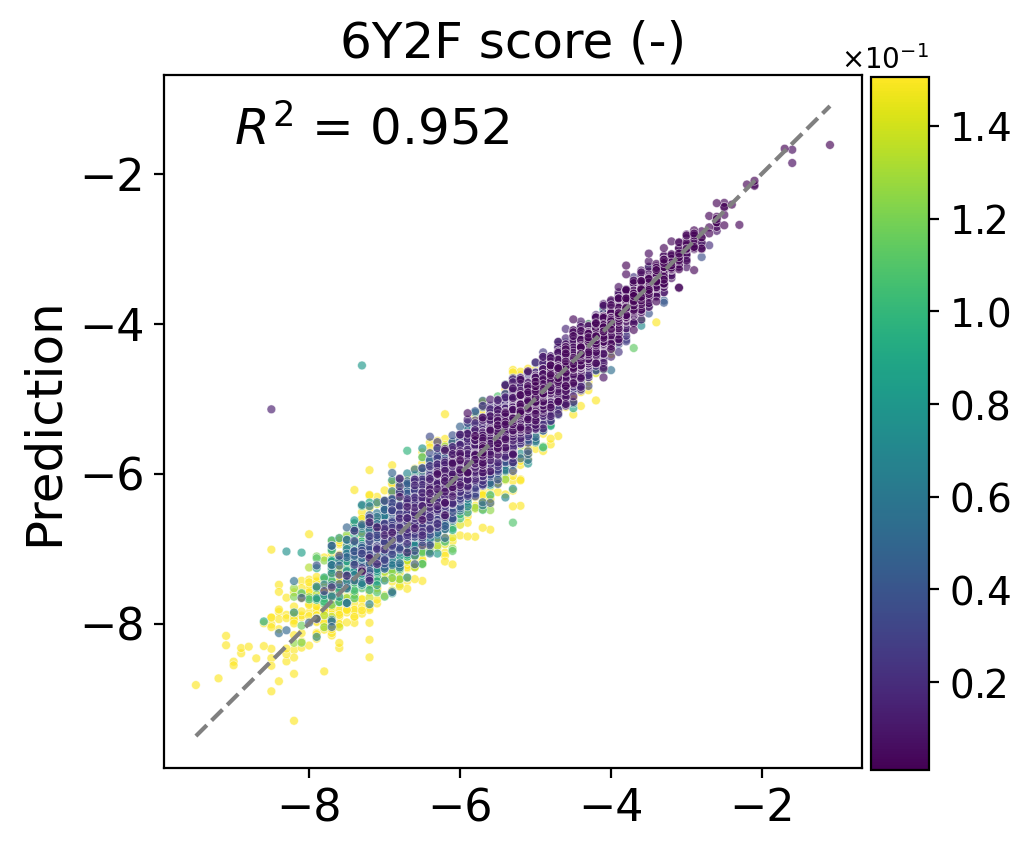

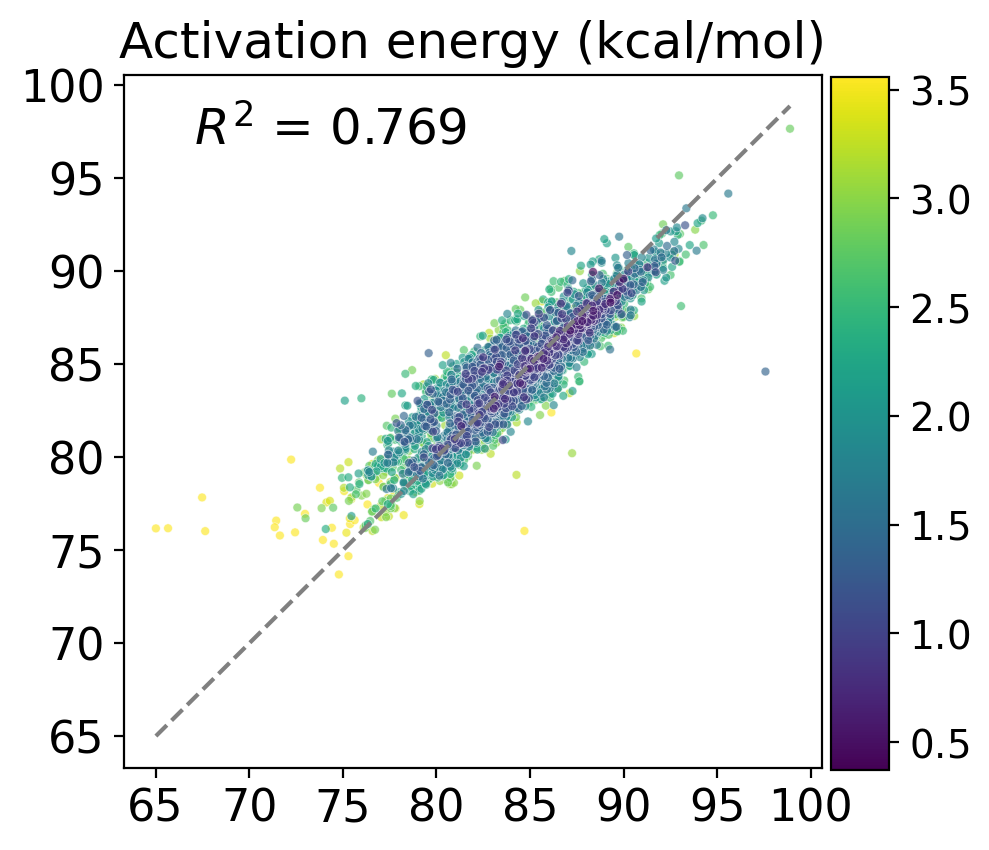

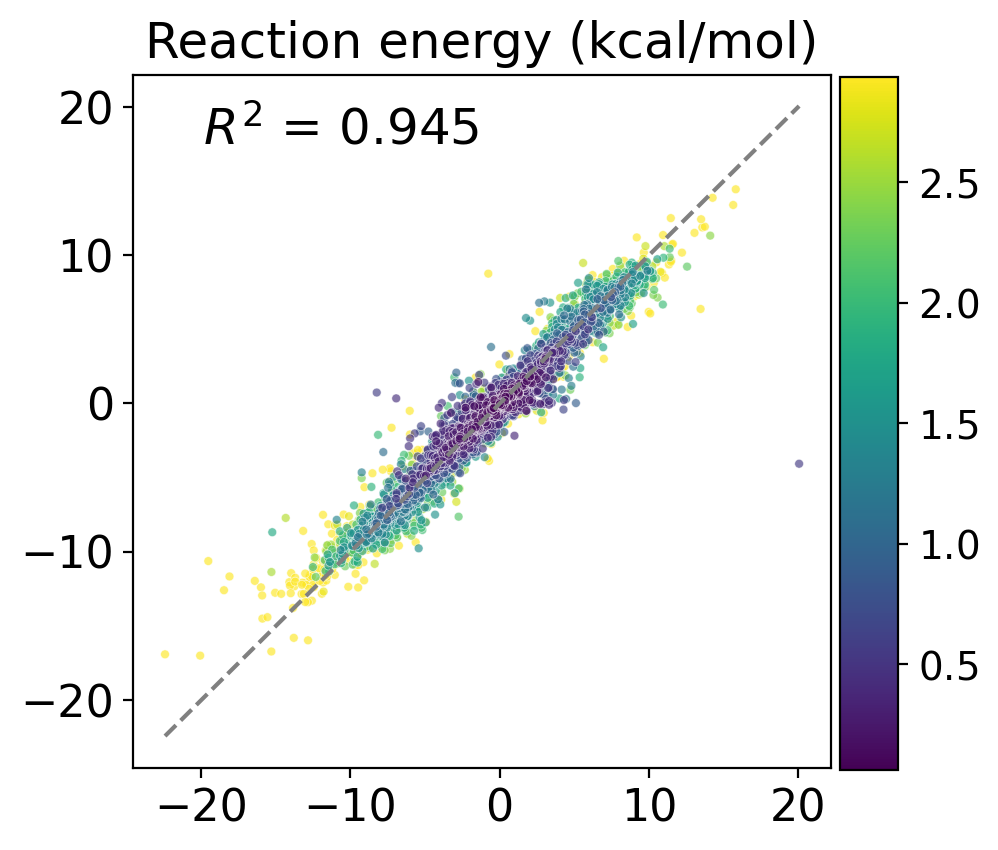

In [37]:
dataset_target = [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee"),
                  ("docking", "1syh score"), ("docking", "4lde score"), ("docking", "6y2f score"),
                  ("reactivity", "activation_energy"), ("reactivity", "reaction_energy")]
scaler_dict = {"1syh score": (-2.832, 8.928), "4lde score": (-7.547, 1.617), "6y2f score": (-5.528, 0.997),
               "singlet-triplet value": (1.003, 0.396), "oscillator strength": (0.086, 0.149), "abs_diff_vee": (2.688, 1.038),
               "activation_energy": (84.104, 3.076), "reaction_energy": (-0.749, 4.507)}
model_dict = {"docking":"chemprop_unc/save_models/docking_evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter_ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity_evidential/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total",
                           "organic_emitter": "mve",
                           "reactivity": "evidential_total"}

# fig = plt.figure(figsize=(14,7), dpi=150)
for i, (dataset, target) in enumerate(dataset_target):
    xlabel = False
    ylabel = False

    if i in [0,5]:
        ylabel = True
    # plt.subplot(int(str(2) + str(4) + str(j )))
    model_path = model_dict[dataset]
    uncertainty_method = uncertainty_method_dict[dataset]
    data = create_data(model_path, [target], scaler_dict, normalize_data=False, uncertainty_method=uncertainty_method)
    data = replace_outliers(data, target+f"_{uncertainty_method}_uncal_var") # activation_energy_evidential_total_uncal_var
    create_single_unc_plot(data, target, uncertainty_method=uncertainty_method, xlabel=xlabel, ylabel=ylabel, color_bar=True, save_path=f"figures/finals/parity_plots/{target}.png")
    

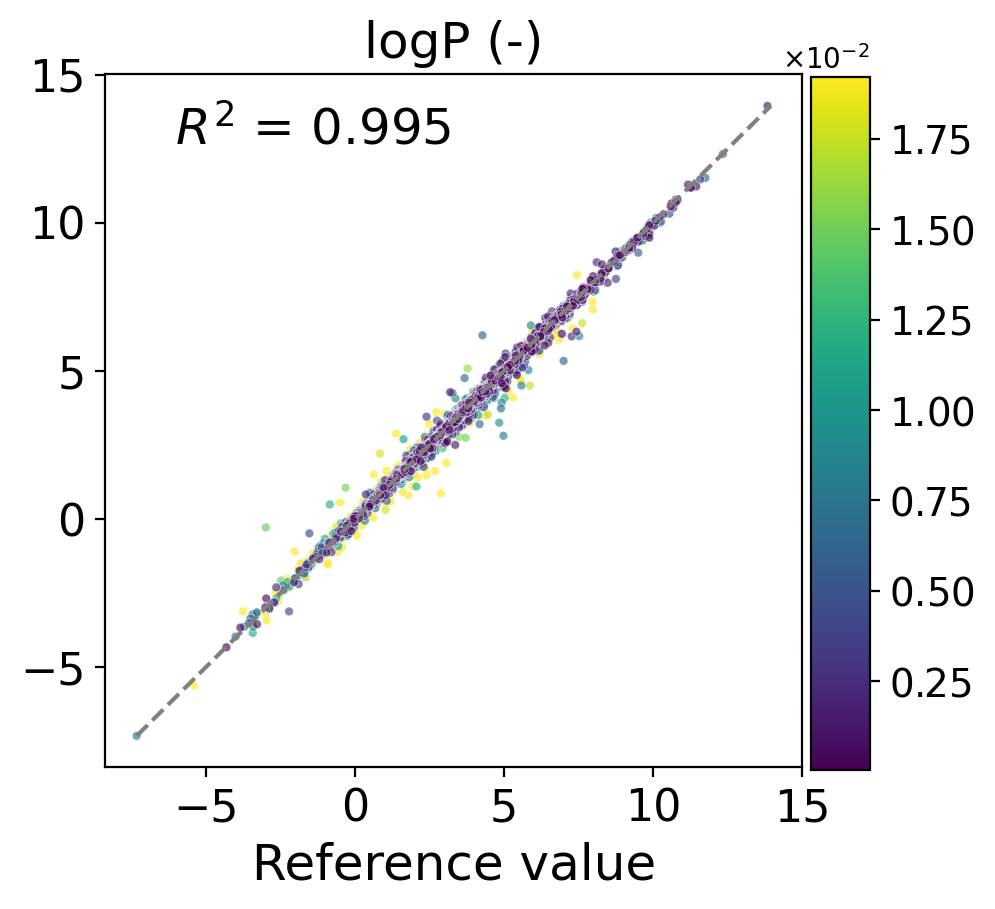

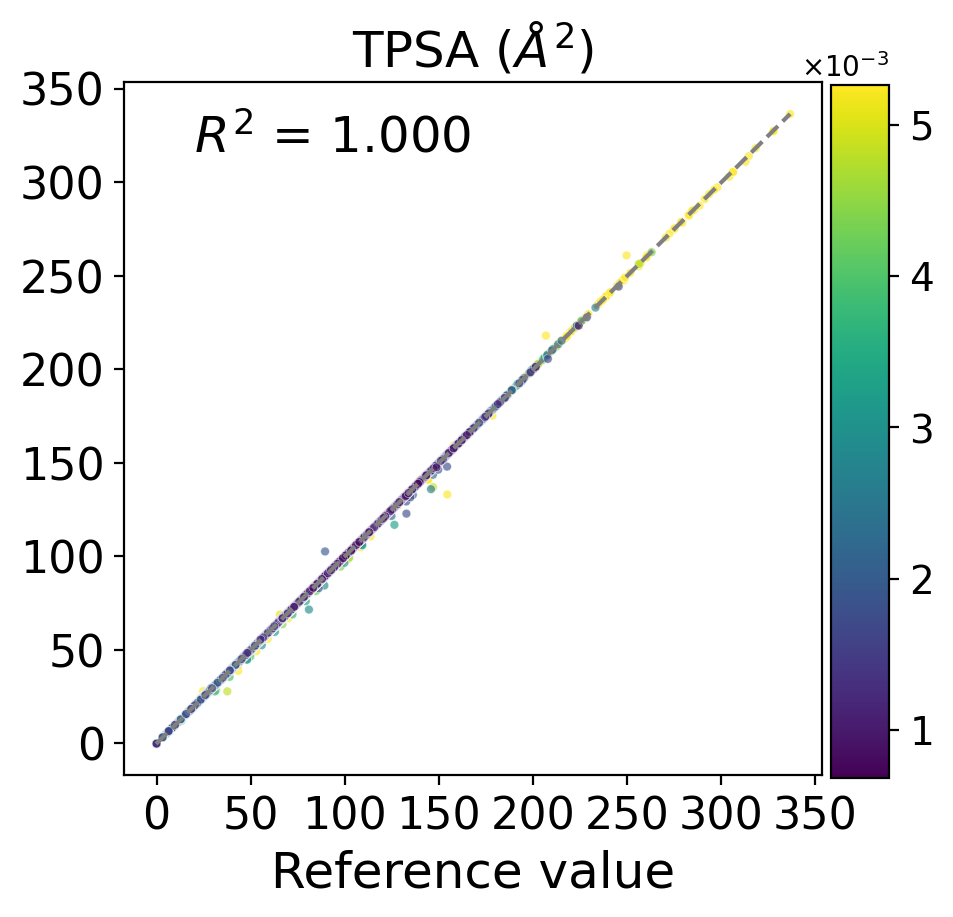

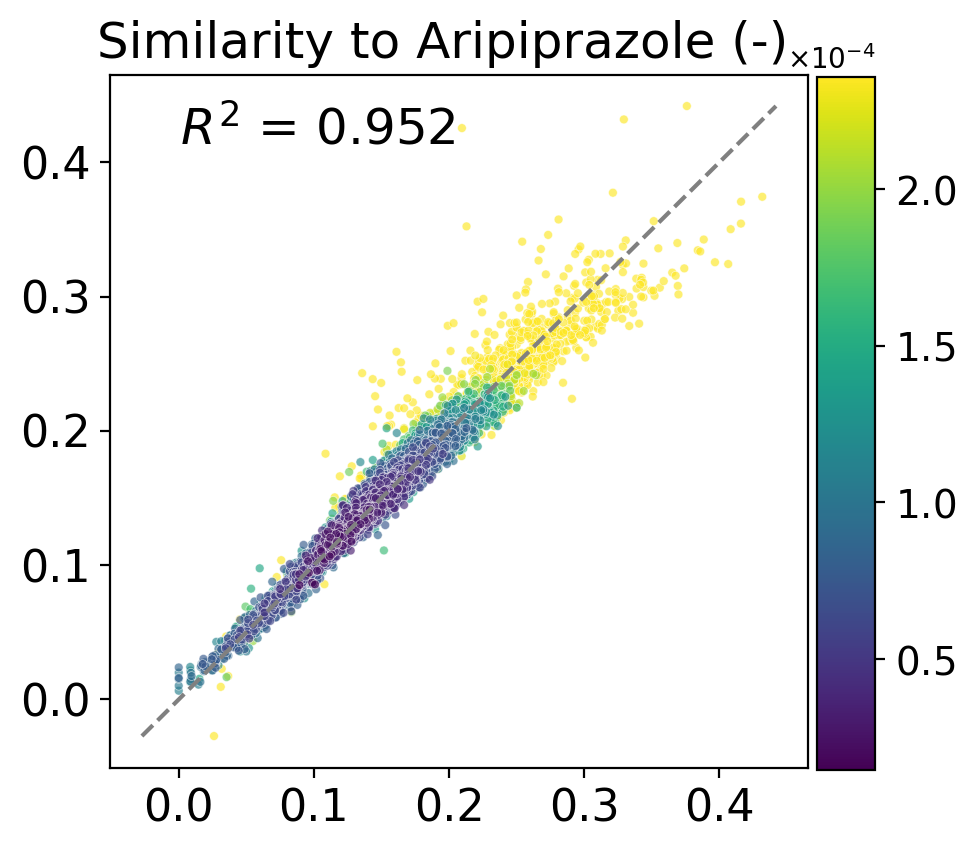

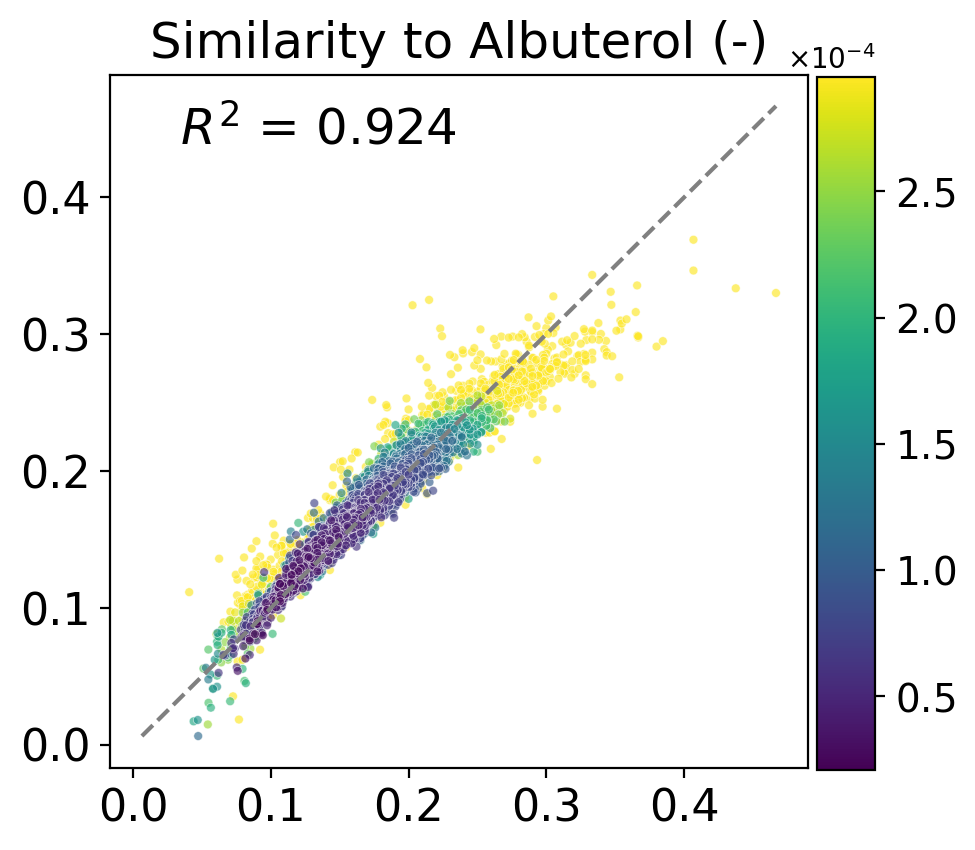

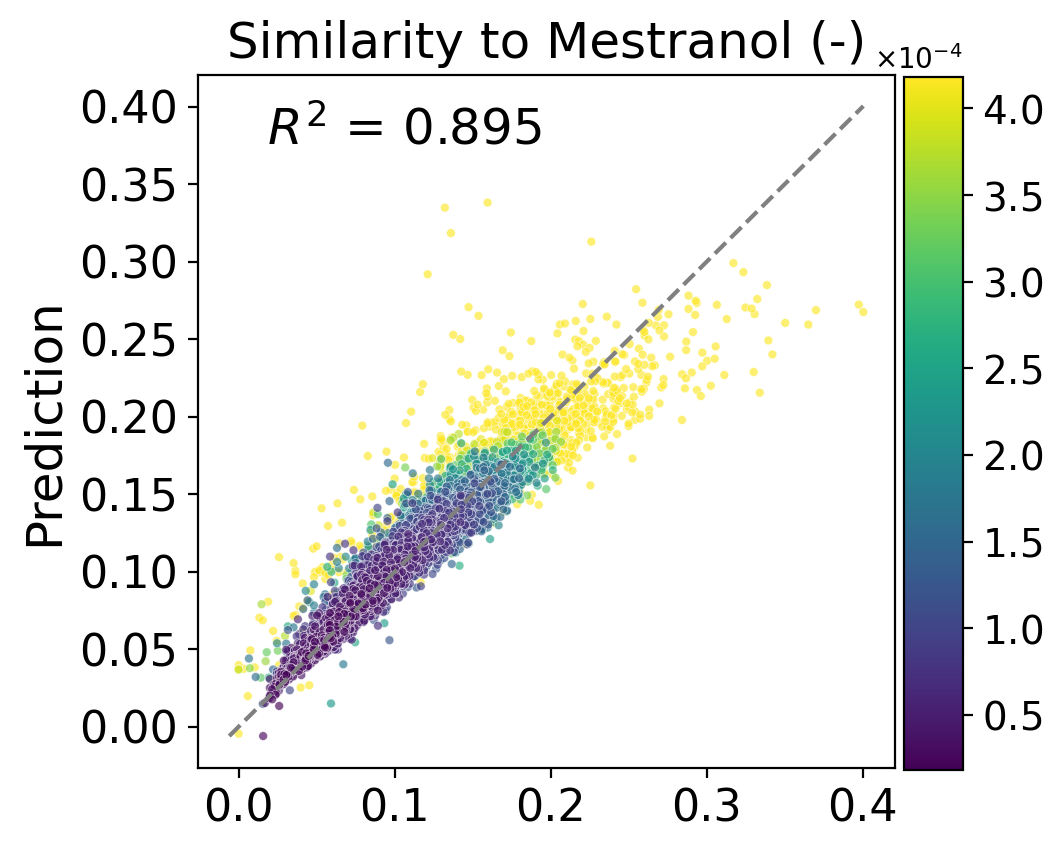

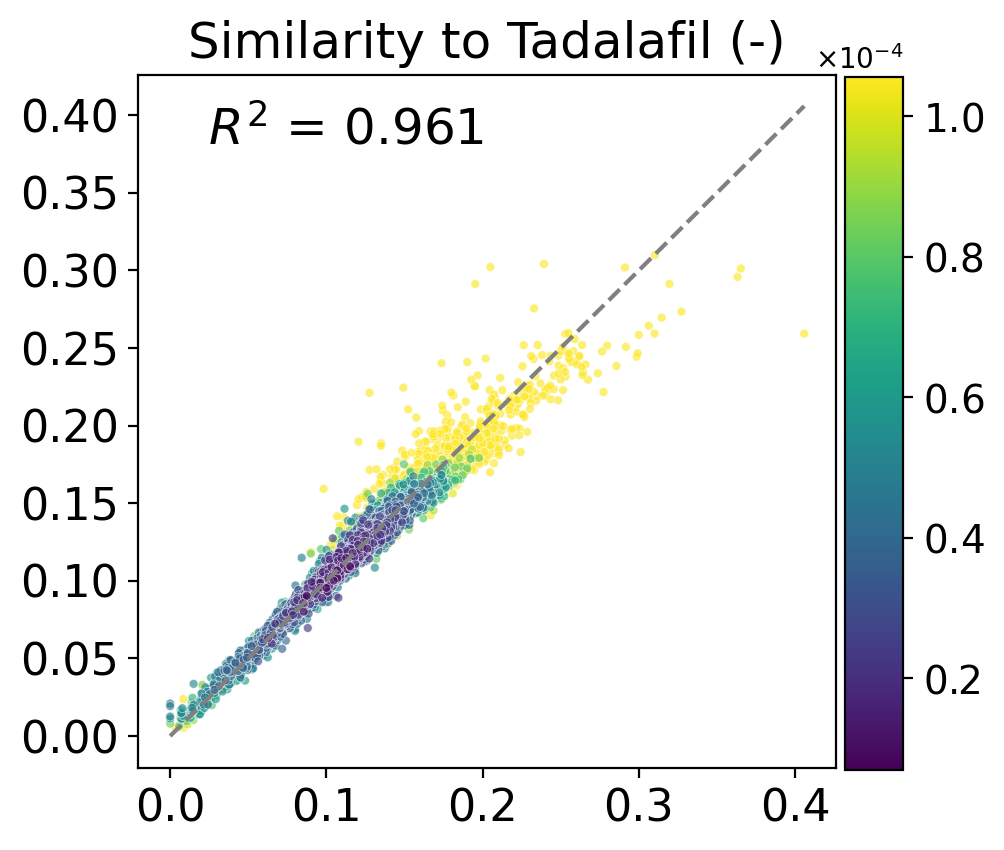

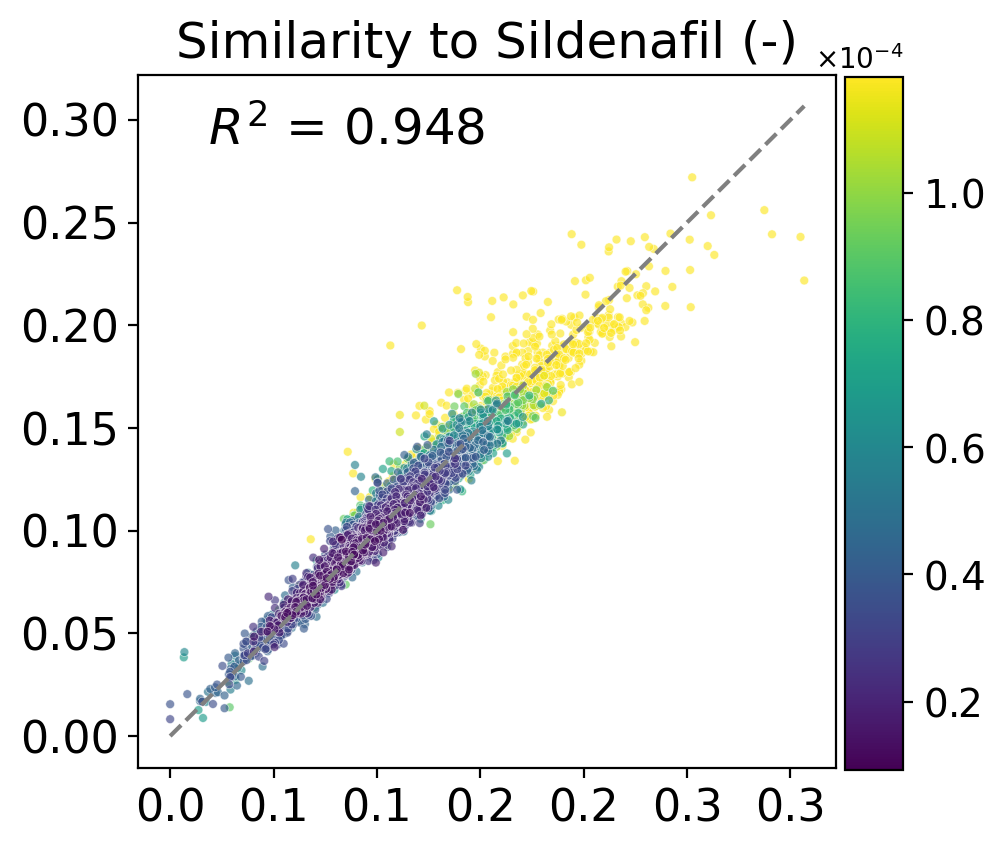

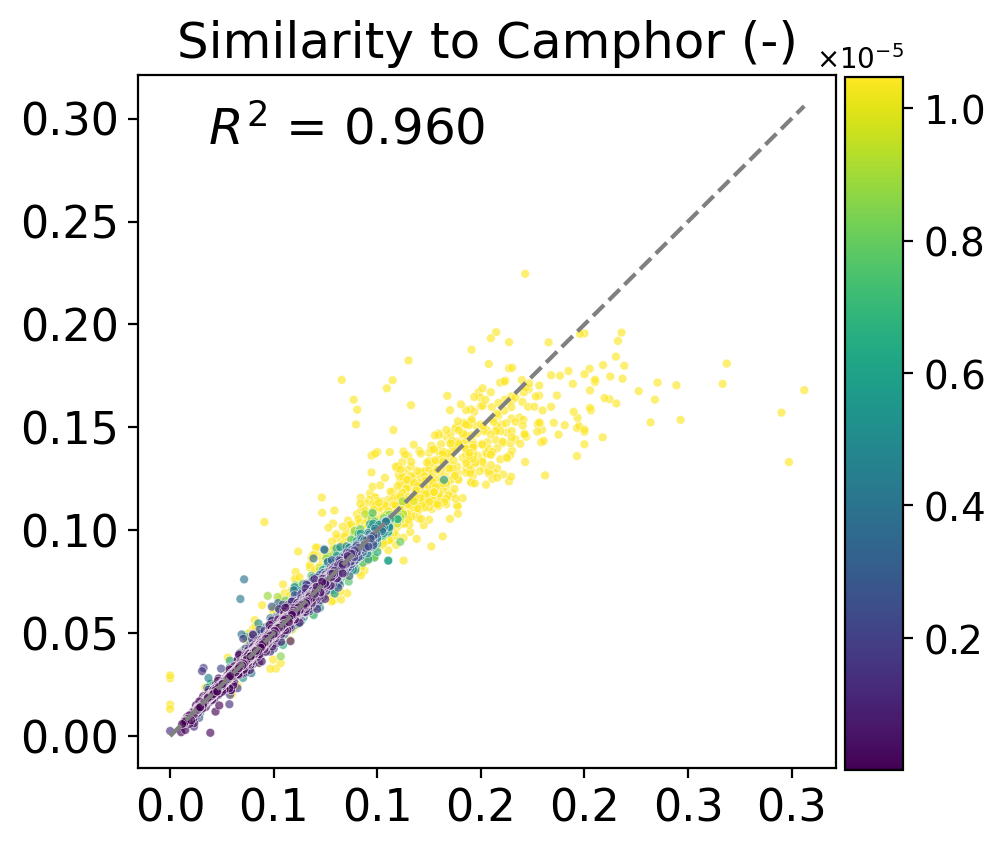

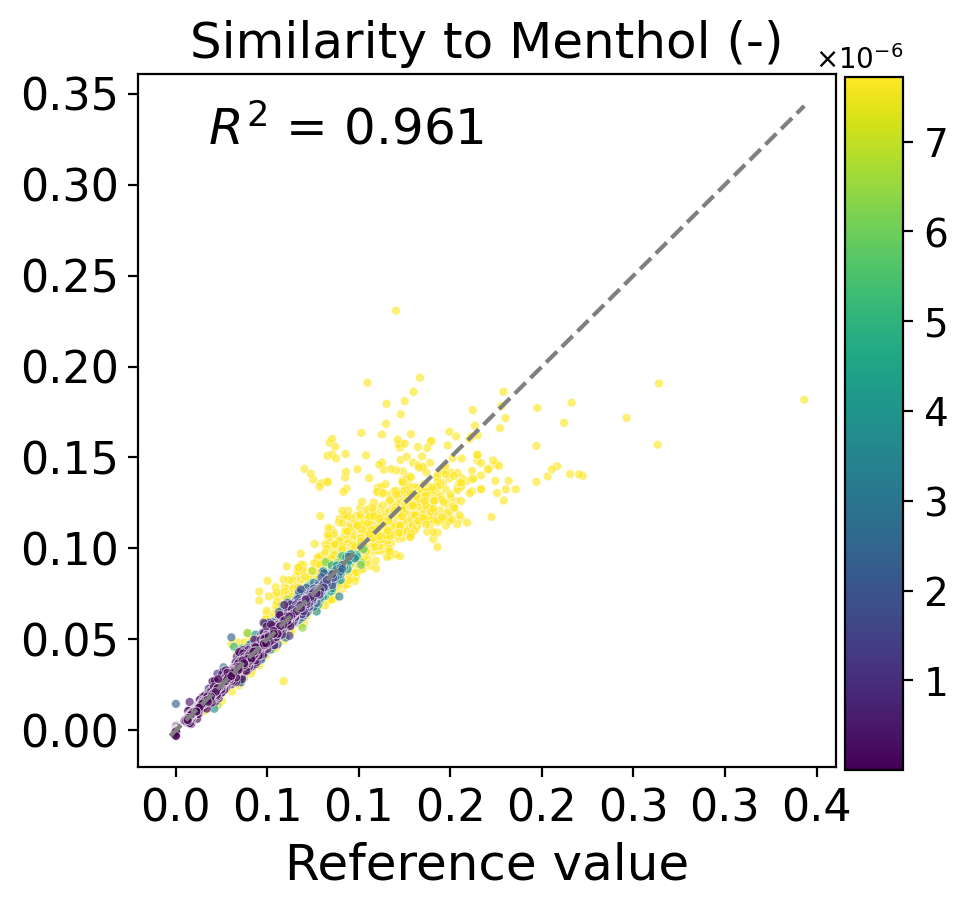

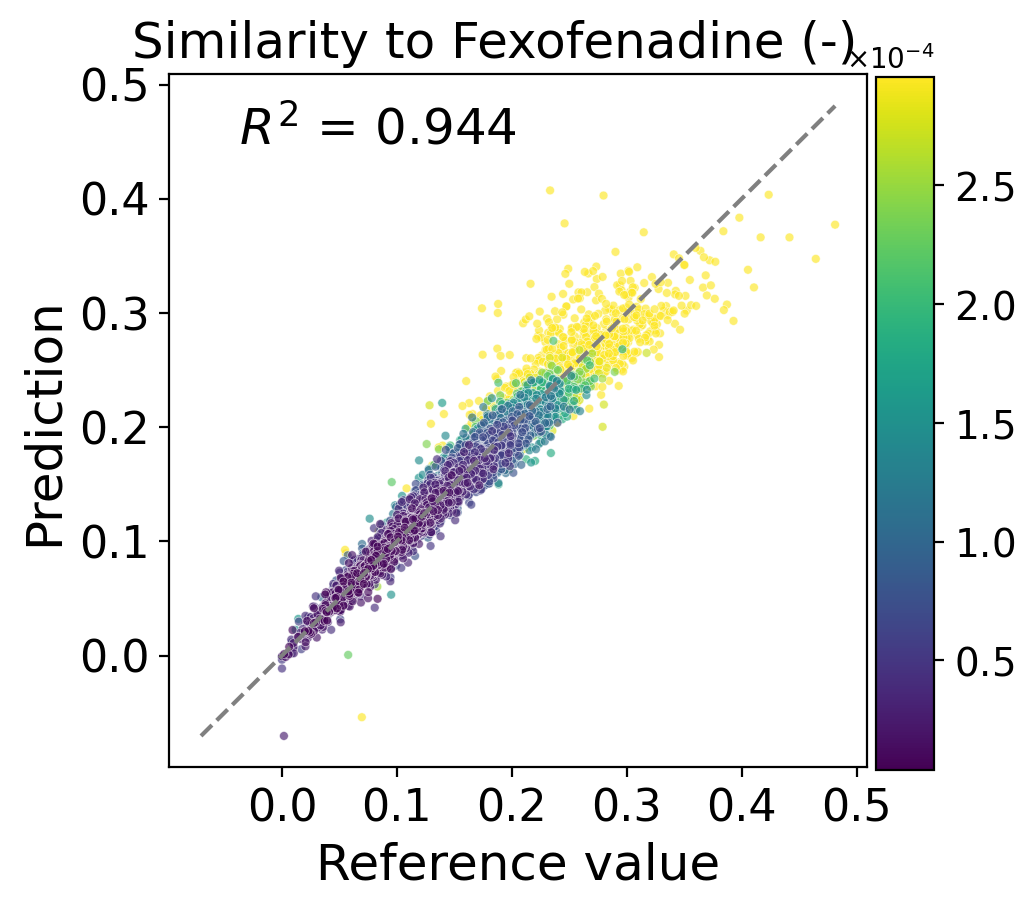

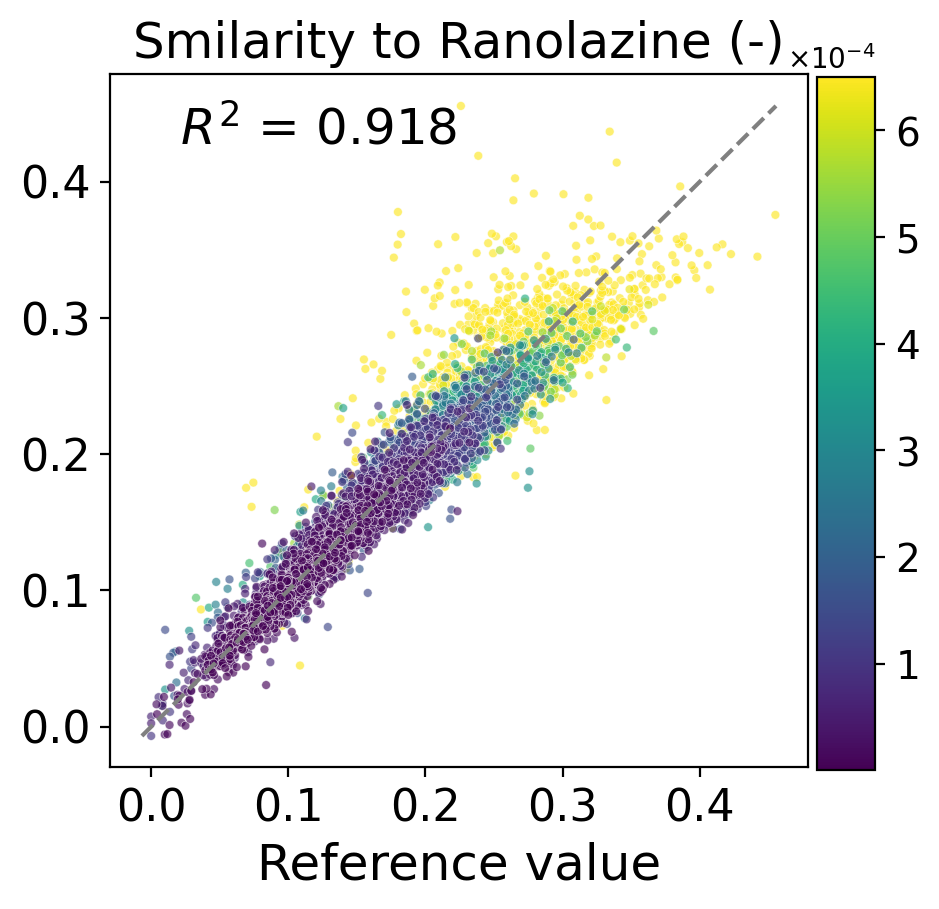

In [50]:
target_columns = ['logP', 'tpsa', 'similarity_Aripiprazole',
       'similarity_Albuterol', 'similarity_Mestranol', 'similarity_Tadalafil',
       'similarity_Sildenafil', 'similarity_Camphor', 'similarity_Menthol',
       'similarity_Fexofenadine', 'similarity_Ranolazine']

target_model_columns = [('logP', 'trial_3'), ('tpsa', 'trial_24'), ('similarity_Aripiprazole', 'trial_30'),
       ('similarity_Albuterol', 'trial_30'), ('similarity_Mestranol', 'trial_30'), ('similarity_Tadalafil', 'trial_30'),
       ('similarity_Sildenafil', 'trial_30'), ('similarity_Camphor', 'trial_24'), ('similarity_Menthol', 'trial_20'),
       ('similarity_Fexofenadine', 'trial_24'), ('similarity_Ranolazine', 'trial_19')]

for target, model in target_model_columns:
       model_path = f"chemprop_unc/save_models/guacamol/{target}/{model}/fold_0"
       uncertainty_method = "evidential_total"
       data = create_data_guacamol(model_path, [target])
       data = replace_outliers(data, target+f"_{uncertainty_method}_uncal_var")
       xlabel = False
       ylabel = False
       if target in ['similarity_Mestranol', 'similarity_Fexofenadine']:
              ylabel = True
       if target in ['similarity_Menthol', 'similarity_Fexofenadine', 'similarity_Ranolazine', 'logP', 'tpsa']:
              xlabel = True
       create_single_unc_plot(data, target, uncertainty_method=uncertainty_method, 
                              xlabel=xlabel, ylabel=ylabel, color_bar=True, save_path=f"figures/finals/parity_plots/{target}.png")


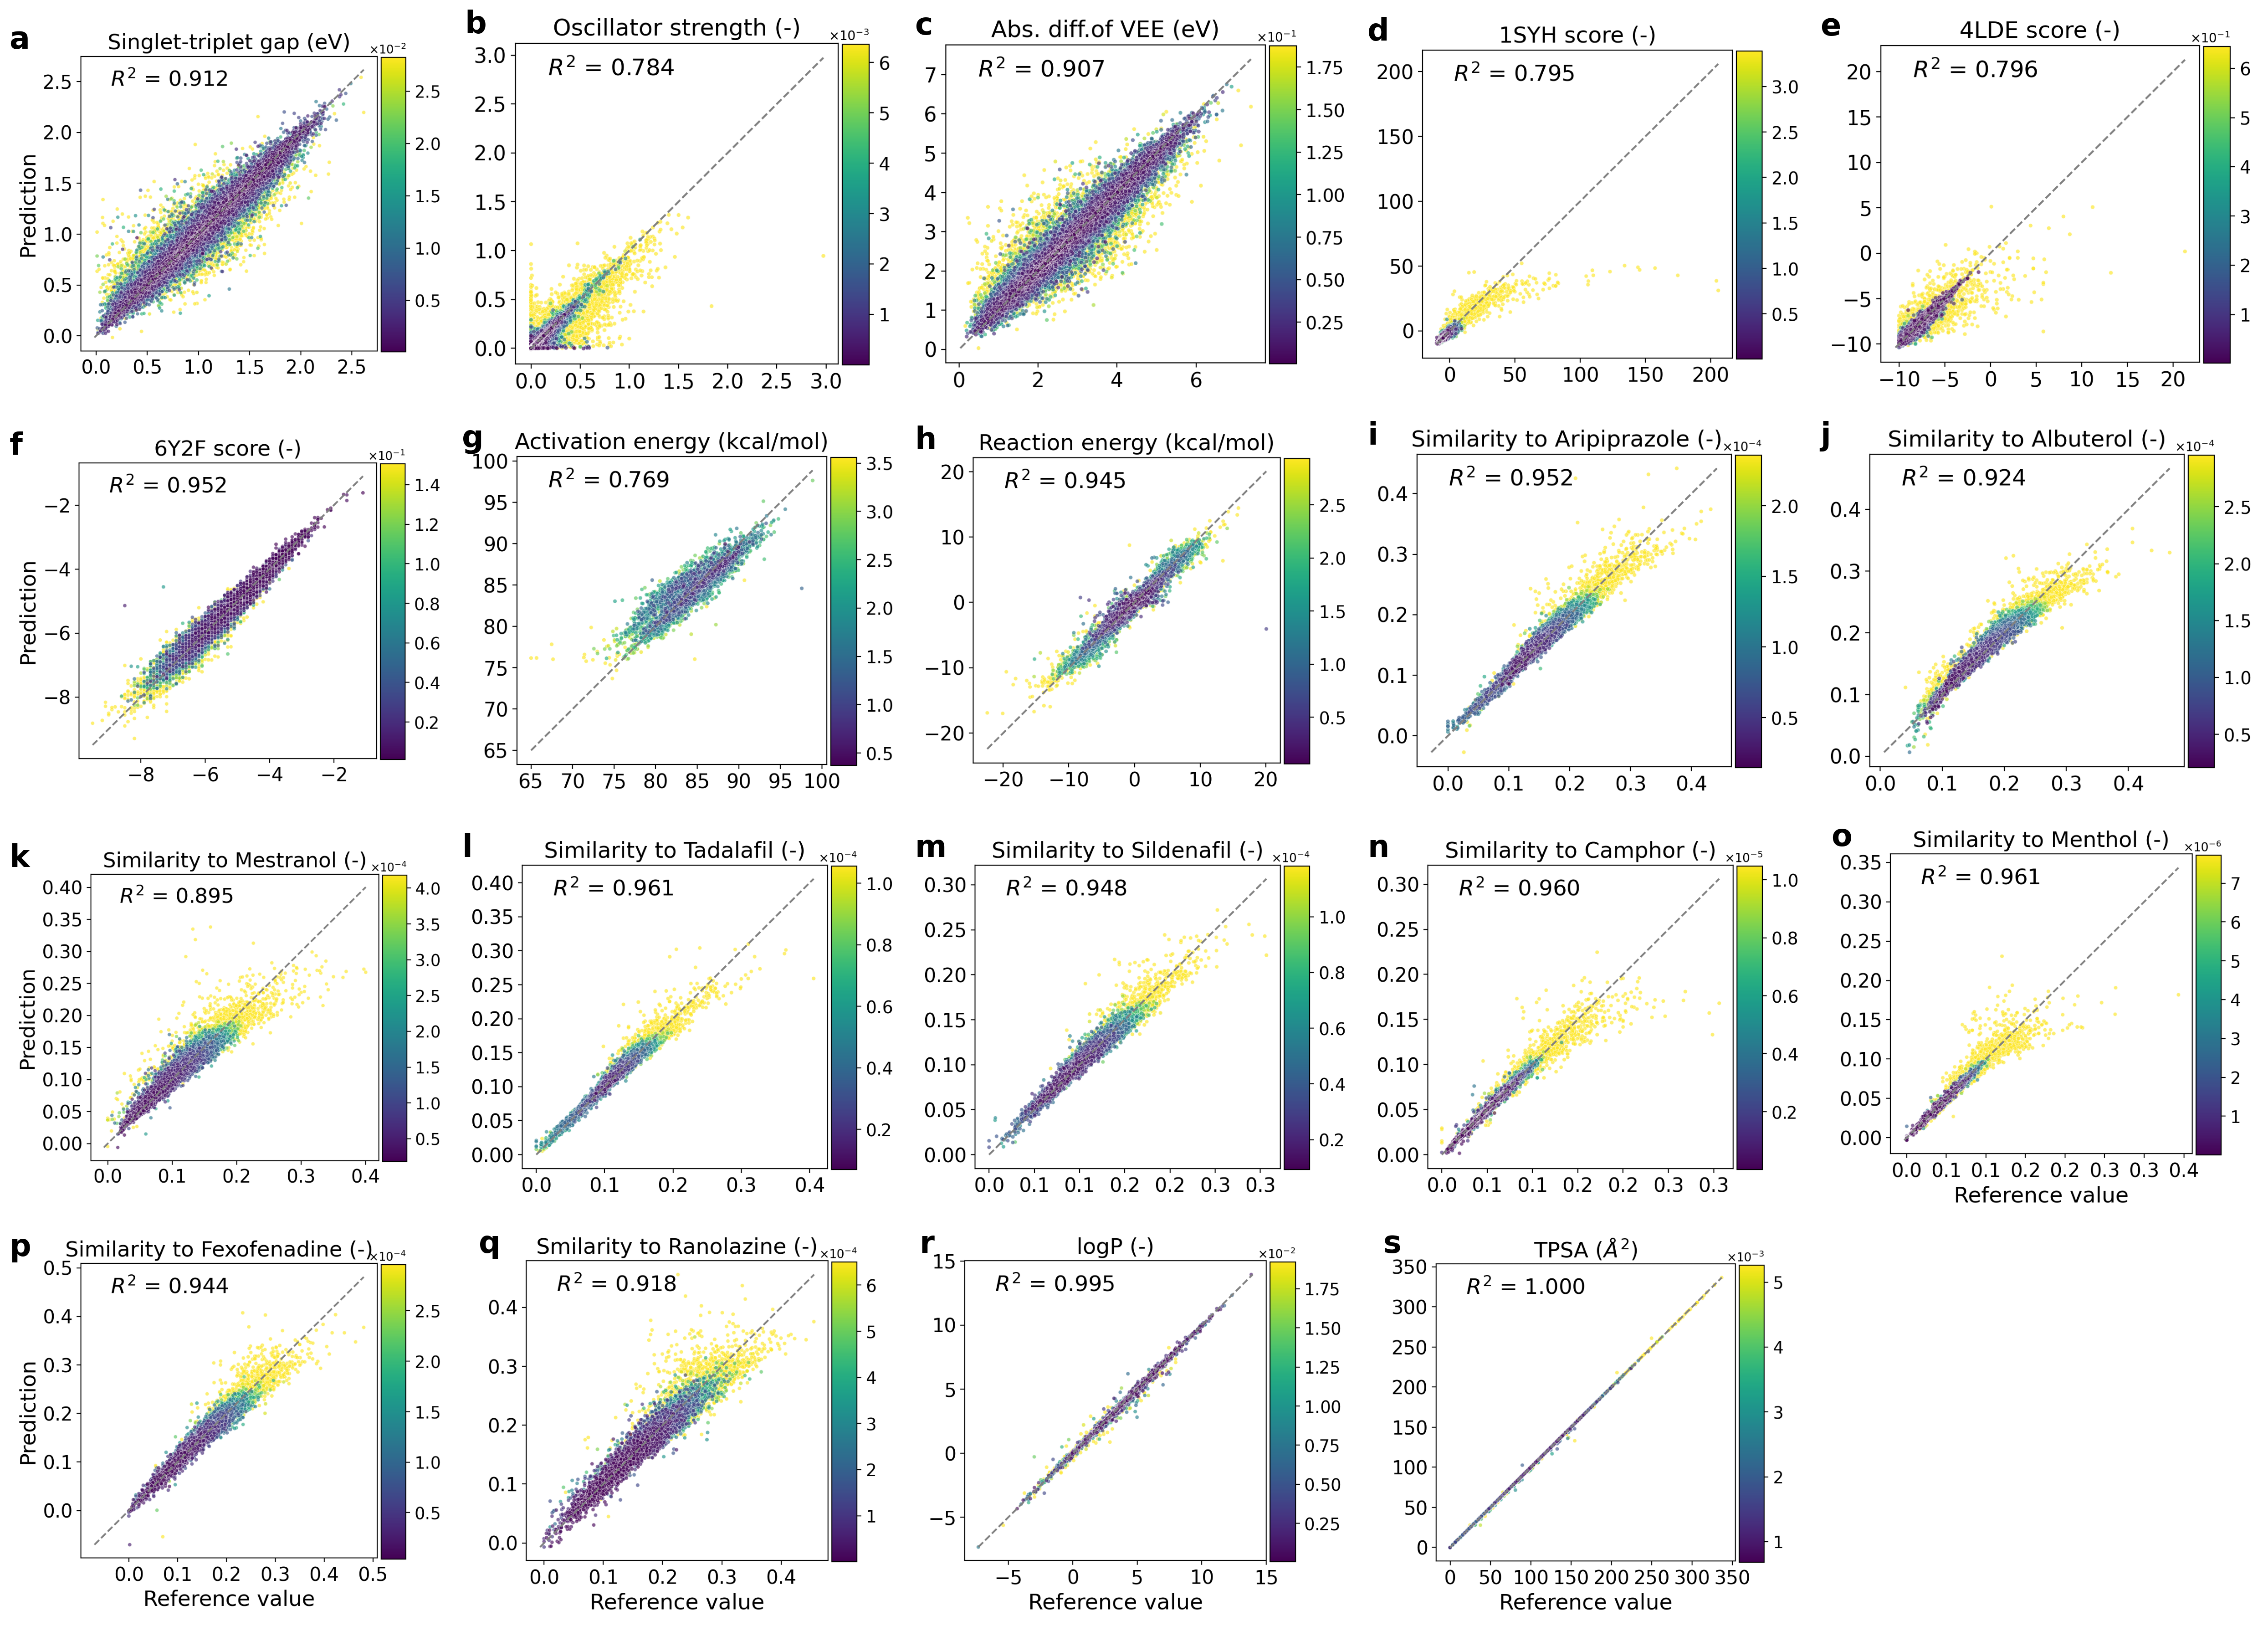

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
import os

image_files = ["singlet-triplet value", "oscillator strength", "abs_diff_vee",
                "1syh score", "4lde score", "6y2f score",
                "activation_energy", "reaction_energy", 'similarity_Aripiprazole',
                'similarity_Albuterol', 'similarity_Mestranol', 'similarity_Tadalafil',
                'similarity_Sildenafil', 'similarity_Camphor', 'similarity_Menthol',
                'similarity_Fexofenadine', 'similarity_Ranolazine', 'logP', 'tpsa',]

image_files = [f"figures/finals/parity_plots/{file_name}.png" for file_name in image_files]

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k','l', 'm','n','o', 'p','q','r','s']

fig, axs = plt.subplots(4, 5, figsize=(25, 18), dpi=200) 

for i, ax in enumerate(axs.flat):
    if i == 19:
        ax.axis('off')
        break
    image_path = image_files[i]
    if os.path.exists(image_path):
        img = Image.open(image_path)
    else:
        continue 

    ax.imshow(img)
    ax.axis('off')
    ax.text(0, 0, labels[i], color='black', fontsize=24, va='top', ha='left', weight="bold")

plt.tight_layout()
plt.savefig('figures/finals/parity_plots/combined.png')
plt.show()


## Plot cutoff-based scalarization

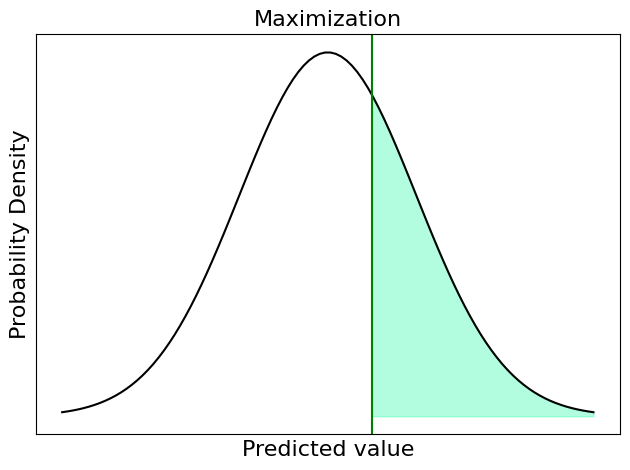

0.3085375387259869


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_gaussian_distribution(mean, std, cutoff=None, greater_than=True, title=None, save_path=None):
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean)/std)**2)

    plt.plot(x, y, color ="black")

    if cutoff is not None:
        plt.axvline(cutoff, color='green')  

        if greater_than:
            fill_x = np.linspace(cutoff, mean + 3*std, 100)
            fill_y = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((fill_x-mean)/std)**2)
            plt.fill_between(fill_x, fill_y, color='mediumspringgreen', alpha=0.3)
        else:
            fill_x = np.linspace(mean - 3*std, cutoff, 100)
            fill_y = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((fill_x-mean)/std)**2)
            plt.fill_between(fill_x, fill_y, color='mediumspringgreen', alpha=0.3)

    plt.title(title,fontsize=16)
    plt.xlabel('Predicted value', fontsize=16)
    plt.ylabel('Probability Density', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="svg")
    plt.show()


def calculate_greater_cdf(cutoff, mean, std):
    '''
    Calculate the cumulative distribution greater than a certain cutoff,
    that is, the probability greater than a certain cutoff
    '''
    return 1 - norm.cdf(cutoff, loc=mean, scale=std)

def calculate_less_cdf(cutoff, mean, std): 
    '''
    Calculate the cumulative distribution smaller than a certain cutoff, that is, 
    the probability of being smaller than a certain cutoff
    '''
    return norm.cdf(cutoff, loc=mean, scale=std)

# test the code
mean = -2.5   
std = 1.
cutoff = -2 
greater_than = True
title = "Maximization"

plot_gaussian_distribution(mean, std, cutoff, greater_than=greater_than, title=title, save_path="figures/plot_probability/maxi.svg")
if greater_than:
    print(calculate_greater_cdf(cutoff, mean, std))
else:
    print(calculate_less_cdf(cutoff, mean, std))

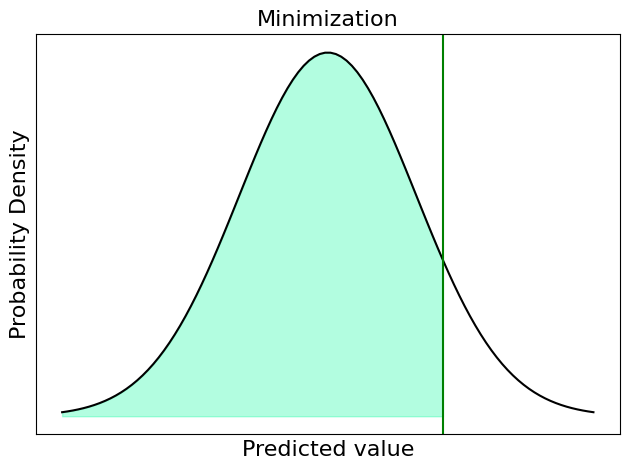

0.9031995154143897


In [19]:
mean = -11.3
std = 1
cutoff = -10
greater_than = False
title = "Minimization"

plot_gaussian_distribution(mean, std, cutoff, greater_than=greater_than, title=title, save_path="figures/plot_probability/mini.svg")
if greater_than:
    print(calculate_greater_cdf(cutoff, mean, std))
else:
    print(calculate_less_cdf(cutoff, mean, std))

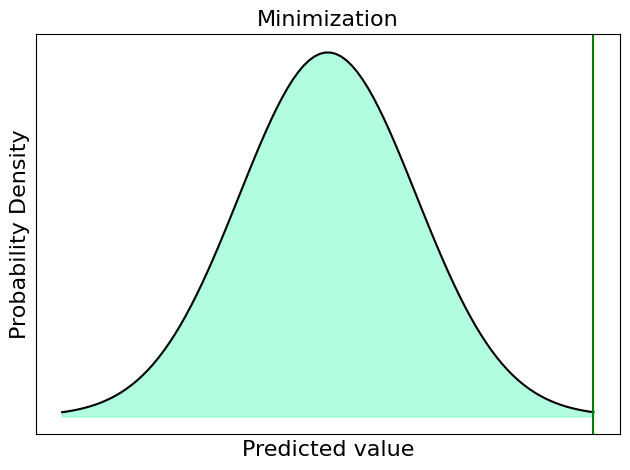

0.9986501019683699


In [24]:
mean = 0
std = 1
cutoff = 3
greater_than = False
title = "Minimization"

plot_gaussian_distribution(mean, std, cutoff, greater_than=greater_than, title=title, save_path="figures/plot_probability/mini_2.svg")
if greater_than:
    print(calculate_greater_cdf(cutoff, mean, std))
else:
    print(calculate_less_cdf(cutoff, mean, std))